<span style="font-familiy:Arial; font-weight:800; font-size:25px"> Compare standard DYCOMS simulations to Ackerman, et al. 2009 simulations </span>

# Setup notebook

## Load packages

In [9]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy.stats

In [10]:
savefigs = False

load_TS = True
load_profiles = True

In [11]:
# import own functions
from importnb import Notebook

with Notebook(): 
        import functions as fkts
        import namelist as nml
        from set_up_case_dict import *

In [12]:
# load a MIMICA file to get the grid
ds_mimica = xr.open_dataset(dct_all["SMD"]["r0_010e-7"]["65e06"]["dir_prf"])

ds_mimica

<xarray.Dataset>
Dimensions:          (Z: 96, VT: 2, time: 361)
Coordinates:
  * Z                (Z) float32 2.512 7.606 12.91 ... 1.382e+03 1.459e+03
  * time             (time) float32 0.0 61.82 120.7 ... 2.154e+04 2.16e+04
Dimensions without coordinates: VT
Data variables: (12/116)
    Z_BD             (Z, VT) float32 ...
    U                (time, Z) float32 ...
    V                (time, Z) float32 ...
    W                (time, Z) float32 ...
    T                (time, Z) float32 ...
    PT               (time, Z) float32 ...
    ...               ...
    Q1_micro_10      (time, Z) float32 ...
    N1_micro_10      (time, Z) float32 ...
    Q2_micro_10      (time, Z) float32 ...
    N2_micro_10      (time, Z) float32 ...
    NAERO1_tend_10   (time, Z) float32 ...
    MAAERO1_tend_10  (time, Z) float32 ...

## load Ackermann, et al. 2009 data
Note: loading data direclty using xarray does result in an MissingDimensionsError
<br> --> use netCDF4 insted  

The Ackerman et al. 2009 simulations include
* **11 modeling groups**
* **14 models** (tree groups with two model versions)
* simulations with and without **drizzle**
* simulations with and without **sedimentation**

The dimension named "drizzle" has a length of 2, with the first (second) 
element corresponding to drizzle being off (on).  Likewise, the first 
(second) element of the dimension named "sed" corresponds to cloud-water 
sedimentation being omitted (included).

In [5]:
# select which cases should be used
# (I don't yet know which index stands for on/off)
idrizz = 1
ised = 1
itime = -1

In [13]:
dir_val_prof = '/home/jovyan/work/data/BLCWG_DYCOMS-II_RF02.profiles.nc'
dir_val_scal = '/home/jovyan/work/data/BLCWG_DYCOMS-II_RF02.scalars.nc'

### Load Scalars

In [14]:
nc = netCDF4.Dataset(dir_val_prof)


In [15]:
list(nc.variables)

['label',
 'missing',
 'time',
 'zmap',
 'nzt',
 'nzw',
 'zt',
 'zw',
 'dz',
 'u',
 'v',
 'thetal',
 'qt',
 'ql',
 'rho',
 'u_var',
 'v_var',
 'w_var',
 'w_skw',
 'sgs_tke',
 'thetal_var',
 'ql_var',
 'qt_var',
 'rad_flx',
 'tot_tw',
 'sgs_tw',
 'tot_qw',
 'sgs_qw',
 'tot_uw',
 'sgs_uw',
 'tot_vw',
 'sgs_vw',
 'tot_shr',
 'tot_boy',
 'transport',
 'dissipation',
 'sgs_boy',
 'precip',
 'ss',
 'cfrac',
 'ndrop_cld',
 'qr',
 'sgs_pr',
 'sgs_shr']

In [16]:
am09_vars = ["w_var", "cfrac", "ndrop_cld", "qt", "ql"]

In [17]:
nc["qr"]

<class 'netCDF4._netCDF4.Variable'>
float32 qr(group, drizzle, sed, ntime, nz)
    units: [g/kg]
    longname: Rain water mixing ratio
unlimited dimensions: 
current shape = (14, 2, 2, 13, 301)
filling on, default _FillValue of 9.969209968386869e+36 used

In [18]:
# get the names of the models
mods = []
for iname in nc["label"]:
    h = []
    [h.append(i.decode("utf-8")) for i in iname.data]
    mods.append("".join(h))
    
print("Model names:")
print(mods)    

Model names:
['COAMPS', 'COAMPS_SL', 'DHARMA', 'DHARMA_BO', 'MetO', 'MPI', 'NHM', 'RAMS', 'Reading', 'SAM', 'UCLA', 'UCLA_SB', 'Utah', 'WVU']


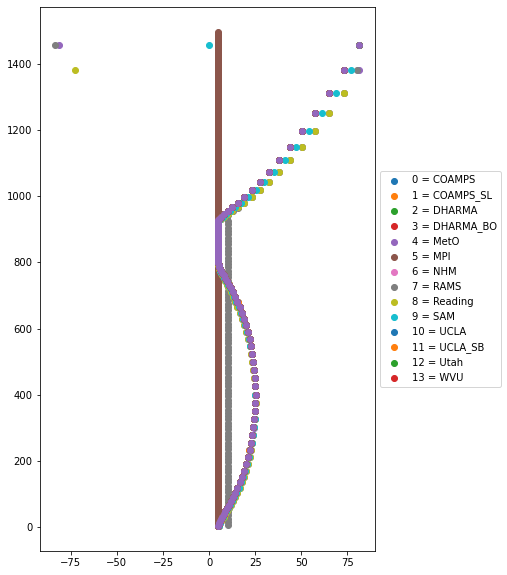

In [19]:
# check out vertical grid
plt.figure(figsize = [6,10])
for imod in range(len(mods)):
    smod = mods[imod]
    plt.scatter(nc["dz"][imod, ised, idrizz].filled(np.nan),\
                nc["zt"][imod, ised, idrizz].filled(np.nan),\
                label = str(imod) + " = " + smod)

    
plt.scatter(ds_mimica["Z_BD"][:,1] - ds_mimica["Z_BD"][:,0], ds_mimica["Z"])
plt.legend(bbox_to_anchor=(1, 0.5), loc = "center left")

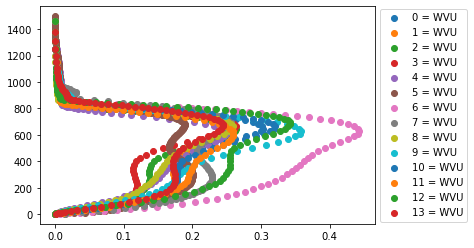

In [20]:
for imod in range(len(mods)):
    plt.scatter(nc["w_var"][imod, idrizz, ised, itime,:].filled(np.nan),\
             nc["zt"][imod, ised, idrizz].filled(np.nan),\
             label = str(imod) + " = " + smod)

    plt.legend(bbox_to_anchor=(1, 0.5), loc = "center left")


In [21]:
# get the vertial grid form MIMICA simulations

In [22]:
list(dct_all["SMD"])

['r0_010e-7',
 'r0_020e-7',
 'r0_030e-7',
 'r0_040e-7',
 'r0_050e-7',
 'r0_060e-7',
 'r0_070e-7',
 'r0_080e-7',
 'r0_090e-7',
 'r0_100e-7',
 'rwet']

In [23]:
w_var = pd.DataFrame(index = ds_mimica.Z)

In [24]:
dct_am09 = {}

In [25]:
for ivar in am09_vars:
    print(ivar)
    idf = pd.DataFrame(index = ds_mimica.Z, columns = mods)
    for imod in range(len(mods)):
        smod = mods[imod]

        for iz in range(len(ds_mimica.Z)):

            z_lo = ds_mimica["Z_BD"][iz,0].values
            z_hi = ds_mimica["Z_BD"][iz,1].values

            z_mod = nc["zt"][imod, ised, idrizz].filled(np.nan)


            zidx = np.where((z_mod >= z_lo) & (z_mod <= z_hi))[0]

            if len(zidx)>0:
                idf.iloc[iz][smod]= np.nanmean(nc[ivar][imod, ised, idrizz, itime, zidx].data)
    dct_am09.update({ivar:idf.copy()})

w_var
cfrac
ndrop_cld
qt
ql


In [26]:
dct_am09["ndrop_cld"]

,COAMPS,COAMPS_SL,DHARMA,DHARMA_BO,MetO,MPI,NHM,RAMS,Reading,SAM,UCLA,UCLA_SB,Utah,WVU
2.511814,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,0.0,0.0,55.0,0.0,0.0,55.0,0.0
7.606128,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,NaN,0.0,55.0,0.0,0.0,55.0,0.0
12.911505,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,0.0,0.0,55.0,0.0,0.0,55.0,0.0
18.565361,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,NaN,0.0,55.0,0.0,0.0,55.0,0.0
24.700222,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,0.0,0.0,55.0,0.0,0.0,55.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197.951416,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,0.0,0.0,55.0,0.0,0.0,55.0,0.0
1251.933716,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,0.0,0.0,55.0,0.0,0.0,55.0,0.0
1313.151123,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,0.0,0.0,55.0,0.0,0.0,55.0,0.0
1382.102661,0.0,0.0,0.0,0.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,9969209968386869046778552952102584320.0,0.0,0.0,55.0,0.0,0.0,55.0,0.0


In [27]:
# remove some weird CDNC values
dct_am09["ndrop_cld"]["NHM"] = np.nan
dct_am09["ndrop_cld"]["MetO"] = np.nan
dct_am09["ndrop_cld"]["MPI"] = np.nan
dct_am09["ndrop_cld"]["SAM"] = np.nan
dct_am09["ndrop_cld"]["Utah"] = np.nan


In [55]:
# Have a look at AM09 models
if False:
    for ivar in am09_vars:
        plt.plot(dct_am09[ivar].min(axis=1), dct_am09[ivar].index)
        plt.plot(dct_am09[ivar].max(axis=1), dct_am09[ivar].index)
        plt.fill_betweenx(x1 =dct_am09[ivar].min(axis=1),\
                          x2 = dct_am09[ivar].max(axis=1),\
                          y = w_var.index,\
                          color = "grey")

        for imod in range(len(mods)):
            plt.plot(dct_am09[ivar][mods[imod]], dct_am09[ivar].index, label = mods[imod])
        plt.title(ivar)
        plt.legend(bbox_to_anchor=(1, 0.5), loc = "center left")
        plt.show()

## Precalculate all model statistics 
(for faster plotting)

In [31]:
dct_mod = {}

In [42]:
# calculate updraft variabiliey
h_df = pd.DataFrame(index = ds_mimica.Z)

for sgrp in dct_all:
    for stype in dct_all[sgrp]:
        for scase in dct_all[sgrp][stype]:
            ids = xr.open_dataset(dct_all[sgrp][stype][scase]["dir_3d"])

            ids_std = ids["W"][-1].var(axis = (1,2))
            h_df[sgrp+stype+scase] = ids_std
dct_mod.update({"w_var":h_df})

/tmp/ipykernel_2819/3857157311.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  h_df[sgrp+stype+scase] = ids_std


In [44]:
# calculate liquid water
h_df = pd.DataFrame(index = ds_mimica.Z)
for sgrp in dct_all:
    for stype in dct_all[sgrp]:
        for scase in dct_all[sgrp][stype]:
            ids = xr.open_dataset(dct_all[sgrp][stype][scase]["dir_prf"])
            h_df[sgrp+stype+scase] = (ids["Qr"][-1]+ids["Qc"][-1])*1000
dct_mod.update({"ql":h_df})

/tmp/ipykernel_2819/1498849667.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  h_df[sgrp+stype+scase] = (ids["Qr"][-1]+ids["Qc"][-1])*1000


In [45]:
# calculate total water
h_df = pd.DataFrame(index = ds_mimica.Z)
for sgrp in dct_all:
    for stype in dct_all[sgrp]:
        for scase in dct_all[sgrp][stype]:
            ids = xr.open_dataset(dct_all[sgrp][stype][scase]["dir_prf"])
            h_df[sgrp+stype+scase] = (ids["Qr"][-1]+ids["Qc"][-1]+ids["Qv"][-1])*1000
dct_mod.update({"qt":h_df})

/tmp/ipykernel_2819/2274352662.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  h_df[sgrp+stype+scase] = (ids["Qr"][-1]+ids["Qc"][-1]+ids["Qv"][-1])*1000


In [46]:
# calculate total water
h_df = pd.DataFrame(index = ds_mimica.Z)
for sgrp in dct_all:
    for stype in dct_all[sgrp]:
        for scase in dct_all[sgrp][stype]:
            ids = xr.open_dataset(dct_all[sgrp][stype][scase]["dir_prf"])
            h_df[sgrp+stype+scase] = (ids["Nc"][-1]+ids["Nr"][-1])/1e6
dct_mod.update({"ndrop_cld":h_df})

/tmp/ipykernel_2819/2830866425.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  h_df[sgrp+stype+scase] = (ids["Nc"][-1]+ids["Nr"][-1])/1e6


# Plot everything

In [49]:
var_plt = ['w_var', 'ndrop_cld', 'qt', 'ql']

In [50]:
lbl_col = []

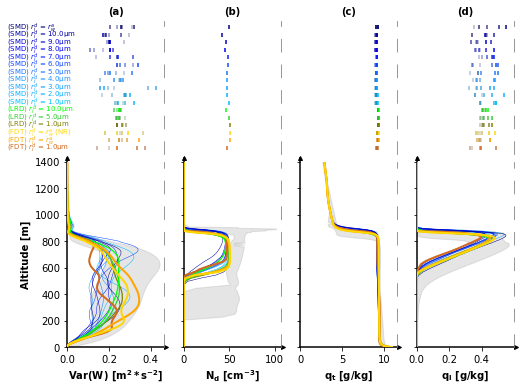

In [53]:
# calculate updraft variabiliey
fix, ax = plt.subplots(ncols = len(var_plt), nrows = 2, figsize = [8,6],\
                       sharey=False, sharex=False,\
                       gridspec_kw={'height_ratios': [2.5, 3.5]})
plt.subplots_adjust(wspace=0.2)
plt.subplots_adjust(hspace=0.05)


for ivar in range(len(var_plt)):
    svar = var_plt[ivar]
    for sgrp in dct_all:
        for stype in dct_all[sgrp]:
            scase = "65e06"
            
            ax[1,ivar].plot(dct_mod[svar][sgrp+stype+scase], ids.Z,\
                    color = dct_all[sgrp][stype][scase]["color_drk"],\
                    zorder = dct_all[sgrp][stype][scase]["zord"],\
                    alpha = dct_all[sgrp][stype][scase]["alpha_up"],\
                    linewidth = dct_all[sgrp][stype][scase]["lw"]*0.25)


for ivar in range(len(var_plt)):
    svar = var_plt[ivar]
    for sgrp in dct_all:
        for stype in dct_all[sgrp]:
            
            for scase in dct_all[sgrp][stype]:
                if (svar == "ndrop_cld") & (scase != "65e06"):
                    continue
                    
                else:
                    if svar == "qt":
                        help_val = [dct_mod[svar][sgrp+stype+scase].median()]
                    else:
                        help_val = [dct_mod[svar][sgrp+stype+scase].max()]
                        
                    ax[0,ivar].scatter(help_val,
                                      dct_all[sgrp][stype][scase]["label"],
                                      marker="|",
                                      s=10,\
                                      color=dct_all[sgrp][stype][scase]["color_drk"],
                                      alpha = dct_all[sgrp][stype][scase]["alpha_up"])
            lbl_col.append(dct_all[sgrp][stype][scase]["color_drk"])
            
                
            
            

    ax[1,ivar].fill_betweenx(x1 =dct_am09[svar].min(axis=1),\
              x2 = dct_am09[svar].max(axis=1),\
              y = w_var.index,\
              color = "grey",\
              alpha = 0.2)




ax[0,0].tick_params(axis='y',labelsize = 7, pad = 60)

for tick in ax[0,0].get_yticklabels():
    tick.set_verticalalignment("center")
    tick.set_horizontalalignment("left")

for color,tick in zip(lbl_col,ax[0,0].yaxis.get_major_ticks()):
    tick.label1.set_color(color) #set the color property

# turn off label in upper row
for iax in ax[0,:]:
    iax.tick_params(axis='y', length = 0, labelsize = 7)
    iax.tick_params(axis='x', length = 0, labelsize = 7)
    iax.xaxis.set_ticklabels([])
    
    for ispine in ["left", "top", "bottom"]:
        iax.spines[ispine].set_visible(False)

# Add dashed lines betwen upper plots
for iax in ax[1,:].flatten():
    iax.spines[ispine].set_visible(True)
    iax.spines["left"].set_color("grey")
    iax.spines["left"].set_linestyle((0,(16,16))) 

# turn off label in lower row
for iax in ax[1,:]:
    for ispine in ["left", "top", "bottom"]:
        iax.spines[ispine].set_visible(False)
        
for iax in ax.flatten():      
    iax.spines["right"].set_color("grey")
    iax.spines["right"].set_linestyle((0,(16,16))) 

        
# make arrows
for iax in ax[1,:]:
    iax.set_xlim(xmin = 0)
    iax.set_ylim(0,1400)

    ymin, ymax = iax.get_ylim()
    xmin, xmax = iax.get_xlim()
    mks = 4
    lwd = 1.5
    iax.plot((xmin, xmax*1.02), (ymin, ymin), color = "k",clip_on=False, linewidth  = lwd)
    iax.plot((xmax*1.02), (ymin), ls="", marker=">", ms=mks, color="k",clip_on=False, linewidth  = lwd)

    iax.plot((xmin, xmin), (ymin, ymax*1.02), color = "k",clip_on=False, linewidth  = lwd )
    iax.plot((xmin), (ymax*1.02), ls="", marker="^", ms=mks, color="k",clip_on=False, linewidth  = lwd)

for iax in ax[0,1:]:
    iax.yaxis.set_ticklabels([])
    
for iax in ax[1,1:]:
    iax.yaxis.set_ticklabels([])
    

    

for iax in range(np.shape(ax)[1]):
    ax[0,iax].set_xlim(ax[1,iax].get_xlim())

ax[1,0].set_ylabel("Altitude [m]", fontweight = "bold")
ax[1,0].set_xlabel("Var(W) [$\mathbf{m^2 * s^{-2}}$]", fontweight = "bold")
ax[1,1].set_xlabel("$\mathbf{N_d}$ $\mathbf{[cm^{-3}]}$", fontweight = "bold")
ax[1,2].set_xlabel("$\mathbf{q_t}$ $\mathbf{[g/kg]}$", fontweight = "bold")
ax[1,3].set_xlabel("$\mathbf{q_l}$ $\mathbf{[g/kg]}$", fontweight = "bold")

abcd = "(a)", "(b)", "(c)", "(d)"
for iax in range(np.shape(ax)[1]):
    ax[0,iax].text(0.5,1.05, abcd[iax], transform=ax[0,iax].transAxes, fontweight = "bold",\
                  ha = "center")

if savefigs:
    plt.savefig(os.path.join(nml.dir_output, "AM09_profile_validation.png"), dpi = 600,\
               bbox_inches = "tight")